In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

SITES = ["MAO", "BSB"]
ZONES = ["DORM1"]
BASE_PATH = Path("../data/processed")

In [2]:
def load_full_parquet(site_id: str, zone: str):
    parquet = BASE_PATH / site_id / f"{site_id}_{zone}_1991-2023_FULL_PIPELINE.parquet"

    df = pd.read_parquet(parquet, engine="fastparquet")

    # garantir datetime (seu código)
    if not np.issubdtype(df["timeset"].dtype, np.datetime64):
        df["timeset"] = pd.to_datetime(df["timeset"], errors="coerce")

    # index temporal (seu código)
    df = df.set_index("timeset").sort_index()

    # metadados úteis para comparar depois
    df["SITE_ID"] = site_id
    df["ZONE"] = zone

    return df


In [3]:
fulls = {}
dfs = []

for site_id in SITES:
    for zone in ZONES:
        df = load_full_parquet(site_id, zone)
        fulls[(site_id, zone)] = df
        dfs.append(df)

df_all = pd.concat(dfs, axis=0)

In [4]:
full = fulls[("MAO", "DORM1")]

In [5]:
full

,site_id,year,month,day,hour,ta_c,tdp_c,rh_pct,p_atm_pa,ghi_Whm2,...,ac_SALA_Heat_P_W,ac_SALA_Cool_P_W,ac_DORM1_Heat_E_kWh,ac_DORM1_Cool_E_kWh,ac_DORM2_Heat_E_kWh,ac_DORM2_Cool_E_kWh,ac_SALA_Heat_E_kWh,ac_SALA_Cool_E_kWh,SITE_ID,ZONE
timeset,,,,,,,,,,,,,,,,,,,,,
1991-01-01 01:00:00,MAO,1991,1,1,1,23.0,23.0,100,100389,0,...,0.0,0.000000,0.0,0.573752,0.0,0.546639,0.0,0.000000,MAO,DORM1
1991-01-01 02:00:00,MAO,1991,1,1,2,23.0,23.0,100,100389,0,...,0.0,0.000000,0.0,0.538535,0.0,0.512329,0.0,0.000000,MAO,DORM1
1991-01-01 03:00:00,MAO,1991,1,1,3,23.0,23.0,100,100389,0,...,0.0,0.000000,0.0,0.510362,0.0,0.484589,0.0,0.000000,MAO,DORM1
1991-01-01 04:00:00,MAO,1991,1,1,4,23.0,23.0,100,100389,0,...,0.0,0.000000,0.0,0.484778,0.0,0.459873,0.0,0.000000,MAO,DORM1
1991-01-01 05:00:00,MAO,1991,1,1,5,23.0,23.0,100,100389,0,...,0.0,0.000000,0.0,0.463842,0.0,0.440847,0.0,0.000000,MAO,DORM1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 20:00:00,MAO,2023,12,31,20,26.0,24.0,89,100398,0,...,0.0,2872.734793,0.0,0.000000,0.0,0.000000,0.0,2.872735,MAO,DORM1
2023-12-31 21:00:00,MAO,2023,12,31,21,25.0,25.0,100,100395,0,...,0.0,2625.722566,0.0,0.000000,0.0,0.000000,0.0,2.625723,MAO,DORM1
2023-12-31 22:00:00,MAO,2023,12,31,22,26.0,25.0,94,100398,0,...,0.0,2448.547730,0.0,0.000000,0.0,0.000000,0.0,2.448548,MAO,DORM1


In [6]:
df_all.groupby("SITE_ID").size()

SITE_ID
BSB    289080
MAO    289080
dtype: int64

Definição de períodos extremos

In [7]:
CRITICAL_DEF = {
    # Definição A: "Extremo relativo ao clima" (top 1%)
    "relative_quantile": 0.99,      # p99 = top 1% das horas

    # Definição B: "Crítico fisiológico absoluto" (interpretable)
    "core_abs_threshold_c": 37.0,   # exemplo: Tcore >= 37°C

    # Para dias críticos
    "min_hours_per_day": 2
}

In [8]:
def make_relative_extreme_flag(df: pd.DataFrame, col: str, q: float = 0.99, suffix: str = None):
    """
    Cria flag booleana de extremo relativo: col >= quantil q (calculado no próprio df).
    Retorna: df com a coluna flag e o valor do limiar usado.
    """
    if col not in df.columns:
        raise KeyError(f"Coluna '{col}' não existe no dataframe.")

    s = df[col].astype(float)
    thr = s.quantile(q, interpolation="linear")  # consistente e simples
    flag_name = suffix or f"flag_extreme_{col}_q{int(q*100)}"

    df[flag_name] = s >= thr
    return df, thr, flag_name

def make_absolute_threshold_flag(df: pd.DataFrame, col: str, thr: float, flag_name: str):
    """
    Cria flag booleana por limiar absoluto (ex.: t_core >= 38°C).
    """
    if col not in df.columns:
        raise KeyError(f"Coluna '{col}' não existe no dataframe.")

    s = df[col].astype(float)
    df[flag_name] = s >= thr
    return df, flag_name

def make_daily_critical_flag(df: pd.DataFrame, hourly_flag_col: str, min_hours_per_day: int = 2,
                            daily_flag_name: str = None):
    """
    Converte flag horária em flag diária:
    dia crítico se tiver >= min_hours_per_day horas críticas.
    """
    if hourly_flag_col not in df.columns:
        raise KeyError(f"Coluna '{hourly_flag_col}' não existe no dataframe.")

    daily_flag_name = daily_flag_name or f"day_critical_{hourly_flag_col}_ge{min_hours_per_day}h"
    daily_counts = df[hourly_flag_col].resample("D").sum().astype(int)
    daily_flag = daily_counts >= min_hours_per_day

    # devolve uma série diária; se quiser “colar” no df horário, dá pra mapear depois
    return daily_counts, daily_flag.rename(daily_flag_name)

def create_critical_flags(full, CRITICAL_DEF):
    """
    Cria todas as flags de períodos críticos em um dataframe `full`.
    Retorna o dataframe modificado.
    """

    REL_VARS = [
        "vn_DORM1_Top_C",
        "vn_DORM1_HeatIndex_C",
        "vn_DORM1_HumidityIndex",
        "ac_DORM1_Cool_P_W",
        "jos3_t_core",
        "jos3_t_skin_mean",
    ]

    for col in REL_VARS:
        if col not in full.columns:
            continue

        full, _, _ = make_relative_extreme_flag(
            full,
            col,
            q=CRITICAL_DEF["relative_quantile"],
            suffix=f"flag_extreme_{col}_p99"
        )

    # fisiológico absoluto
    if "jos3_t_core" in full.columns:
        full["flag_critical_core_abs"] = (
            full["jos3_t_core"] >= CRITICAL_DEF["core_abs_threshold_c"]
        )

    return full


In [9]:
for site_id in fulls:
    fulls[site_id] = create_critical_flags(fulls[site_id], CRITICAL_DEF)

In [10]:
# 2A) Definição A (relativa): top 1% por variável
REL_VARS = [
    "vn_DORM1_Top_C",
    "vn_DORM1_HeatIndex_C",
    "vn_DORM1_HumidityIndex",
    "ac_DORM1_Cool_P_W",
    "jos3_t_core",
    "jos3_t_skin_mean",
]

thresholds_used = {}  # guarda os limiares p99 por variável
flags_created = []

for col in REL_VARS:
    if col in full.columns:
        full, thr, flag = make_relative_extreme_flag(
            full, col,
            q=CRITICAL_DEF["relative_quantile"],
            suffix=f"flag_extreme_{col}_p99"
        )
        thresholds_used[col] = thr
        flags_created.append(flag)

thresholds_used, flags_created[:5], len(flags_created)

({'vn_DORM1_Top_C': np.float64(36.633216241494715),
  'vn_DORM1_HeatIndex_C': np.float64(46.66154981802573),
  'vn_DORM1_HumidityIndex': np.float64(49.6380282451774),
  'ac_DORM1_Cool_P_W': np.float64(1169.312495509289),
  'jos3_t_core': np.float64(36.88),
  'jos3_t_skin_mean': np.float64(35.89)},
 ['flag_extreme_vn_DORM1_Top_C_p99',
  'flag_extreme_vn_DORM1_HeatIndex_C_p99',
  'flag_extreme_vn_DORM1_HumidityIndex_p99',
  'flag_extreme_ac_DORM1_Cool_P_W_p99',
  'flag_extreme_jos3_t_core_p99'],
 6)

In [11]:
# 2B) Definição B (absoluta fisiológica): core acima do limiar

if "jos3_t_core" in full.columns:
    full, flag_core_abs = make_absolute_threshold_flag(
        full,
        col="jos3_t_core",
        thr=CRITICAL_DEF["core_abs_threshold_c"],
        flag_name="flag_critical_core_abs"
    )

# (opcional) Dia crítico para core absoluto 
daily_core_hours, daily_core_crit = make_daily_critical_flag(
    full, "flag_critical_core_abs",
    min_hours_per_day=CRITICAL_DEF["min_hours_per_day"]
)

daily_core_hours.head(), daily_core_crit.head()

(timeset
 1991-01-01    0
 1991-01-02    0
 1991-01-03    0
 1991-01-04    0
 1991-01-05    0
 Freq: D, Name: flag_critical_core_abs, dtype: int64,
 timeset
 1991-01-01    False
 1991-01-02    False
 1991-01-03    False
 1991-01-04    False
 1991-01-05    False
 Freq: D, Name: day_critical_flag_critical_core_abs_ge2h, dtype: bool)

In [12]:
# Quantas horas críticas deu por flag (deve ser ~1% para p99; core_abs depende do clima)
summary = {}
for f in flags_created + (["flag_critical_core_abs"] if "flag_critical_core_abs" in full.columns else []):
    summary[f] = {
        "n_hours": int(full[f].sum()),
        "pct_hours": float(full[f].mean()*100)
    }

pd.DataFrame(summary).T.sort_values("pct_hours", ascending=False)

,n_hours,pct_hours
flag_extreme_jos3_t_core_p99,4046.0,1.399613
flag_extreme_jos3_t_skin_mean_p99,2892.0,1.000415
flag_extreme_vn_DORM1_Top_C_p99,2891.0,1.000069
flag_extreme_vn_DORM1_HumidityIndex_p99,2891.0,1.000069
flag_extreme_vn_DORM1_HeatIndex_C_p99,2891.0,1.000069
flag_extreme_ac_DORM1_Cool_P_W_p99,2891.0,1.000069
flag_critical_core_abs,15.0,0.005189


In [13]:
# Conferir se o limiar e o % fazem sentido
for k,v in list(thresholds_used.items())[:6]:
    print(f"{k}: p99={v:.3f}")

vn_DORM1_Top_C: p99=36.633
vn_DORM1_HeatIndex_C: p99=46.662
vn_DORM1_HumidityIndex: p99=49.638
ac_DORM1_Cool_P_W: p99=1169.312
jos3_t_core: p99=36.880
jos3_t_skin_mean: p99=35.890


Coocorrência simultânea entre indicadores (hora a hora)

Índice de Jaccard

J(A,B)=∣A∩B∣/∣A∪B∣

0 → nunca ocorrem juntos
1 → sempre ocorrem juntos

In [14]:
# Flags a comparar 
FLAGS = {
    "Top": "flag_extreme_vn_DORM1_Top_C_p99",
    "HI": "flag_extreme_vn_DORM1_HeatIndex_C_p99",
    "Energy": "flag_extreme_ac_DORM1_Cool_P_W_p99",
    "Core_rel": "flag_extreme_jos3_t_core_p99",
}

# manter apenas flags existentes
FLAGS = {k:v for k,v in FLAGS.items() if v in full.columns}

# checagem rápida
full[list(FLAGS.values())].mean().sort_values(ascending=False) * 100

flag_extreme_jos3_t_core_p99             1.399613
flag_extreme_vn_DORM1_Top_C_p99          1.000069
flag_extreme_vn_DORM1_HeatIndex_C_p99    1.000069
flag_extreme_ac_DORM1_Cool_P_W_p99       1.000069
dtype: float64

In [15]:
def jaccard_index(a: pd.Series, b: pd.Series):
    """
    Calcula índice de Jaccard entre duas séries booleanas.
    Ignora NaNs automaticamente.
    """
    a = a.astype(bool)
    b = b.astype(bool)
    intersection = (a & b).sum()
    union = (a | b).sum()
    return intersection / union if union > 0 else np.nan

In [16]:
labels = list(FLAGS.keys())
jaccard_mat = pd.DataFrame(index=labels, columns=labels, dtype=float)

for i, li in enumerate(labels):
    for j, lj in enumerate(labels):
        jaccard_mat.loc[li, lj] = jaccard_index(
            full[FLAGS[li]],
            full[FLAGS[lj]]
        )

jaccard_mat

,Top,HI,Energy,Core_rel
Top,1.000000,0.154092,0.000000,0.546711
HI,0.154092,1.000000,0.002427,0.282967
Energy,0.000000,0.002427,1.000000,0.011077
Core_rel,0.546711,0.282967,0.011077,1.000000


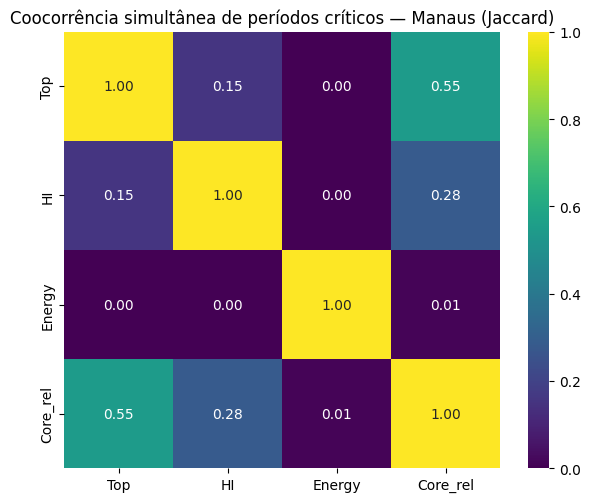

In [17]:
plt.figure(figsize=(6,5))
sns.heatmap(
    jaccard_mat,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    vmin=0, vmax=1,
    square=True
)
plt.title("Coocorrência simultânea de períodos críticos — Manaus (Jaccard)")
plt.tight_layout()
plt.show()

Core_abs: Probabilidade condicional

P(Indicador∣Core_abs)

In [18]:
core_abs = full["flag_critical_core_abs"]

cond = {}
for name, flag in FLAGS.items():
    if flag == "flag_critical_core_abs":
        continue
    cond[name] = (full.loc[core_abs, flag].mean() * 100)

pd.Series(cond).rename("P(indicador extremo | Core_abs) [%]")

Top          46.666667
HI          100.000000
Energy       13.333333
Core_rel    100.000000
Name: P(indicador extremo | Core_abs) [%], dtype: float64

P(Core_abs∣Indicador)

In [19]:
inv = {}
for name, flag in FLAGS.items():
    if flag == "flag_critical_core_abs":
        continue
    inv[name] = (full.loc[full[flag], "flag_critical_core_abs"].mean() * 100)

pd.Series(inv).rename("P(Core_abs | indicador extremo) [%]")

Top         0.242131
HI          0.518852
Energy      0.069180
Core_rel    0.370737
Name: P(Core_abs | indicador extremo) [%], dtype: float64

Análise de ondas de calor

Risk Ratio (RR)

Para cada indicador crítico:

RR=P(critico∣HW)/P(critico∣No HW)

Interpretação:

RR = 1 → HW não muda nada
RR > 1 → HW aumenta a chance de período crítico
RR < 1 → período crítico ocorre mais fora de HW

In [20]:
def risk_ratio(flag_critical: pd.Series, flag_hw: pd.Series):
    """
    Calcula Risk Ratio = P(critical | HW) / P(critical | no HW)
    """
    # garantir boolean
    c = flag_critical.astype(bool)
    h = flag_hw.astype(bool)

    p_hw = c[h].mean()
    p_no = c[~h].mean()

    if p_no == 0:
        return np.nan

    return p_hw / p_no

In [21]:
CRIT_FLAGS = {
    "Top": "flag_extreme_vn_DORM1_Top_C_p99",
    "HI": "flag_extreme_vn_DORM1_HeatIndex_C_p99",
    "Energy": "flag_extreme_ac_DORM1_Cool_P_W_p99",
    "Core_rel": "flag_extreme_jos3_t_core_p99",
    "Core_abs": "flag_critical_core_abs"
}

HW_FLAGS = {
    "INMET": "HW_INMET_bool",
    "Ouzeau": "HW_OU_bool"
}

rows = []

for crit_name, crit_col in CRIT_FLAGS.items():
    for hw_name, hw_col in HW_FLAGS.items():
        rr = risk_ratio(full[crit_col], full[hw_col])
        rows.append({
            "Indicator": crit_name,
            "HW_def": hw_name,
            "Risk_Ratio": rr
        })

rr_df = pd.DataFrame(rows)
rr_df

,Indicator,HW_def,Risk_Ratio
0,Top,INMET,21.445009
1,Top,Ouzeau,31.559856
2,HI,INMET,6.676022
3,HI,Ouzeau,7.082850
4,Energy,INMET,12.033518
5,Energy,Ouzeau,11.678331
6,Core_rel,INMET,20.104696
7,Core_rel,Ouzeau,20.273977
8,Core_abs,INMET,0.000000
9,Core_abs,Ouzeau,25.844292


In [22]:
INDICATORS = {
    "Top": "flag_extreme_vn_DORM1_Top_C_p99",
    "HI": "flag_extreme_vn_DORM1_HeatIndex_C_p99",
    "Energy": "flag_extreme_ac_DORM1_Cool_P_W_p99",
    "Core_rel": "flag_extreme_jos3_t_core_p99",
    "Core_abs": "flag_critical_core_abs",
}

results_rr = []

for site_id, full in fulls.items():
    for ind, col in INDICATORS.items():
        if col not in full.columns:
            print(f"[WARN] {col} não existe em {site_id}")
            continue

        rr_inmet = risk_ratio(full[col], full["HW_INMET_bool"])
        rr_ouz   = risk_ratio(full[col], full["HW_OU_bool"])

        results_rr.append({
            "SITE": site_id,
            "Indicator": ind,
            "HW_def": "INMET",
            "Risk_Ratio": rr_inmet
        })
        results_rr.append({
            "SITE": site_id,
            "Indicator": ind,
            "HW_def": "Ouzeau",
            "Risk_Ratio": rr_ouz
        })

rr_all = pd.DataFrame(results_rr)

In [23]:
results_rr = []

for site_id, full in fulls.items():   # fulls = {"MAO": df, "BSB": df, "SAO": df}
    
    # garantir coluna cooling padronizada
    full["DORM1_cool_W"] = pd.to_numeric(full["ac_DORM1_Cool_P_W"], errors="coerce")

    for ind, col in {
        "Top": "flag_extreme_vn_DORM1_Top_C_p99",
        "HI": "flag_extreme_vn_DORM1_HeatIndex_C_p99",
        "Energy": "flag_extreme_ac_DORM1_Cool_P_W_p99",
        "Core_rel": "flag_extreme_jos3_t_core_p99",
        "Core_abs": "flag_critical_core_abs",
    }.items():

        rr_inmet = risk_ratio(full[col], full["HW_INMET_bool"])
        rr_ouz   = risk_ratio(full[col], full["HW_OU_bool"])

        results_rr.append({
            "SITE": site_id,
            "Indicator": ind,
            "HW_def": "INMET",
            "Risk_Ratio": rr_inmet
        })
        results_rr.append({
            "SITE": site_id,
            "Indicator": ind,
            "HW_def": "Ouzeau",
            "Risk_Ratio": rr_ouz
        })

rr_all = pd.DataFrame(results_rr)

Risk Ratio por cidade

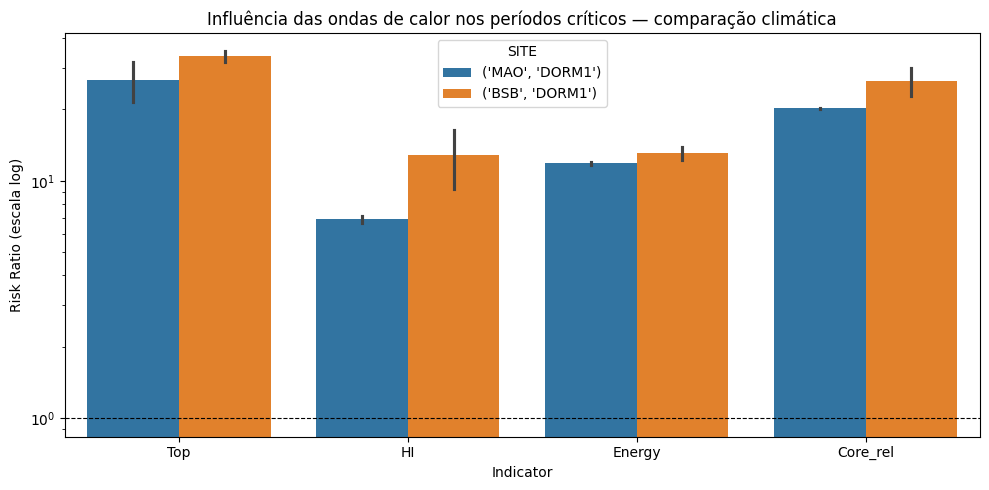

In [40]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=rr_all.query("Indicator != 'Core_abs'"),
    x="Indicator",
    y="Risk_Ratio",
    hue="SITE"
)
plt.yscale("log")  # MUITO recomendado
plt.axhline(1, color="k", ls="--", lw=0.8)
plt.title("Influência das ondas de calor nos períodos críticos — comparação climática")
plt.ylabel("Risk Ratio (escala log)")
plt.tight_layout()
plt.show()

Core_abs isolado

In [32]:
if isinstance(rr_all["SITE"].iloc[0], tuple):
    rr_all[["SITE_ID", "ZONE"]] = pd.DataFrame(rr_all["SITE"].tolist(), index=rr_all.index)
else:
    rr_all["SITE_ID"] = rr_all["SITE"]
    rr_all["ZONE"] = "DORM1"  # ou deixe vazio

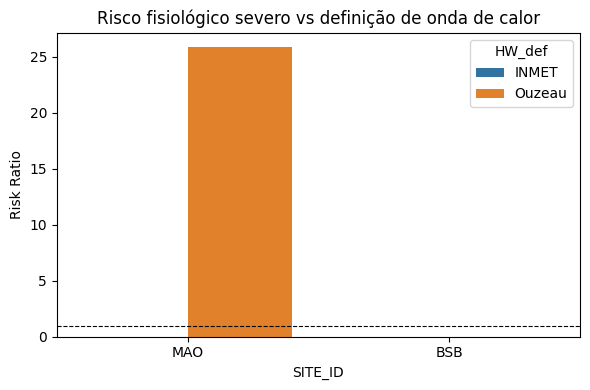

In [33]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=rr_all.query("Indicator == 'Core_abs'"),
    x="SITE_ID",
    y="Risk_Ratio",
    hue="HW_def"
)
plt.axhline(1, color="k", ls="--", lw=0.8)
plt.title("Risco fisiológico severo vs definição de onda de calor")
plt.ylabel("Risk Ratio")
plt.tight_layout()
plt.show()


Frequência absoluta de períodos críticos

In [29]:
freq_rows = []

for site_id, full in fulls.items():
    for ind, col in {
        "Top": "flag_extreme_vn_DORM1_Top_C_p99",
        "Energy": "flag_extreme_ac_DORM1_Cool_P_W_p99",
        "Core_rel": "flag_extreme_jos3_t_core_p99",
        "Core_abs": "flag_critical_core_abs",
    }.items():
        freq_rows.append({
            "SITE": site_id,
            "Indicator": ind,
            "Hours_critical": full[col].sum()
        })

freq_df = pd.DataFrame(freq_rows)


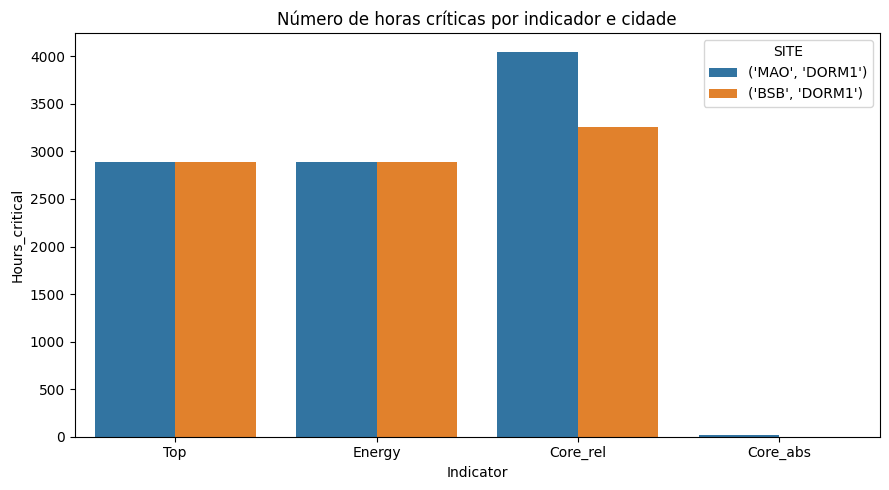

In [31]:
plt.figure(figsize=(9,5))
sns.barplot(
    data=freq_df,
    x="Indicator",
    y="Hours_critical",
    hue="SITE"
)
#plt.yscale("log")
plt.title("Número de horas críticas por indicador e cidade")
plt.tight_layout()
plt.show()


In [76]:
def risk_ratio_vs_category(df, crit_col, category_col="HW_category"):
    out = {}
    base = df[category_col] == "No heatwave"
    p_base = df.loc[base, crit_col].mean()

    for cat in df[category_col].unique():
        if cat == "No heatwave":
            continue
        p_cat = df.loc[df[category_col] == cat, crit_col].mean()
        out[cat] = p_cat / p_base if p_base > 0 else np.nan

    return out

In [77]:
full["HW_category"].value_counts()

HW_category
No heatwave    285044
Ouzeau only      3961
Both               50
INMET only         25
Name: count, dtype: int64

In [78]:
rows = []

for crit_name, crit_col in CRIT_FLAGS.items():
    rr_cat = risk_ratio_vs_category(full, crit_col)
    for cat, rr in rr_cat.items():
        rows.append({
            "Indicator": crit_name,
            "HW_category": cat,
            "Risk_Ratio": rr
        })

rr_cat_df = pd.DataFrame(rows)
rr_cat_df.sort_values(["Indicator", "HW_category"])

,Indicator,HW_category,Risk_Ratio
14,Core_abs,Both,0.000000
12,Core_abs,INMET only,0.000000
13,Core_abs,Ouzeau only,26.168231
11,Core_rel,Both,23.602369
9,Core_rel,INMET only,29.049070
10,Core_rel,Ouzeau only,20.282463
8,Energy,Both,23.963346
6,Energy,INMET only,19.170677
7,Energy,Ouzeau only,15.064057
5,HI,Both,0.000000


Deslocamento temporal entre indicadores críticos

In [79]:
def lagged_jaccard(a: pd.Series, b: pd.Series, lags=range(-24, 25)):
    """
    Calcula Jaccard(a(t+lag), b(t)) para vários lags.
    lag > 0: a ocorre DEPOIS de b
    lag < 0: a ocorre ANTES de b
    """
    out = []
    for lag in lags:
        a_shift = a.shift(lag)
        j = jaccard_index(a_shift.fillna(False), b)
        out.append({"lag_h": lag, "jaccard": j})
    return pd.DataFrame(out)

In [80]:
lags = range(-24, 25)

df_lag_core_top = lagged_jaccard(
    full["flag_extreme_jos3_t_core_p99"],
    full["flag_extreme_vn_DORM1_Top_C_p99"],
    lags=lags
)

df_lag_core_energy = lagged_jaccard(
    full["flag_extreme_jos3_t_core_p99"],
    full["flag_extreme_ac_total_cool_W_p99"],
    lags=lags
)


C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\1864442825.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  j = jaccard_index(a_shift.fillna(False), b)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\1864442825.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  j = jaccard_index(a_shift.fillna(False), b)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\1864442825.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

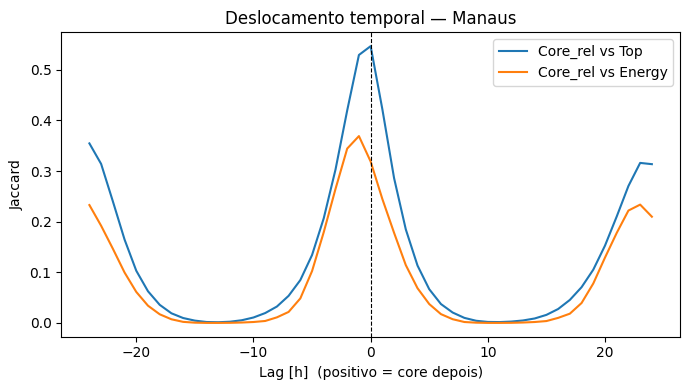

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(df_lag_core_top["lag_h"], df_lag_core_top["jaccard"], label="Core_rel vs Top")
plt.plot(df_lag_core_energy["lag_h"], df_lag_core_energy["jaccard"], label="Core_rel vs Energy")
plt.axvline(0, color="k", ls="--", lw=0.8)
plt.xlabel("Lag [h]  (positivo = core depois)")
plt.ylabel("Jaccard")
plt.legend()
plt.title("Deslocamento temporal — Manaus")
plt.tight_layout()
plt.show()

Análises exploratórias adicionais:

Panorama temporal dos dados

In [6]:
print("Período:", full.index.min(), "→", full.index.max())
print("Registros:", len(full))

# distribuição de anos
annual_count = full.resample("YE")["HW_INMET_bool"].count()
print("anos simulados:", annual_count.shape[0])


Período: 1991-01-01 01:00:00 → 2024-01-01 00:00:00
Registros: 289080
anos simulados: 34


C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\4062310656.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  full["HW_INMET_bool"].resample("Y").sum().plot(label="INMET", lw=2)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\4062310656.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  full["HW_OU_bool"].resample("Y").sum().plot(label="Ouzeau", lw=2)


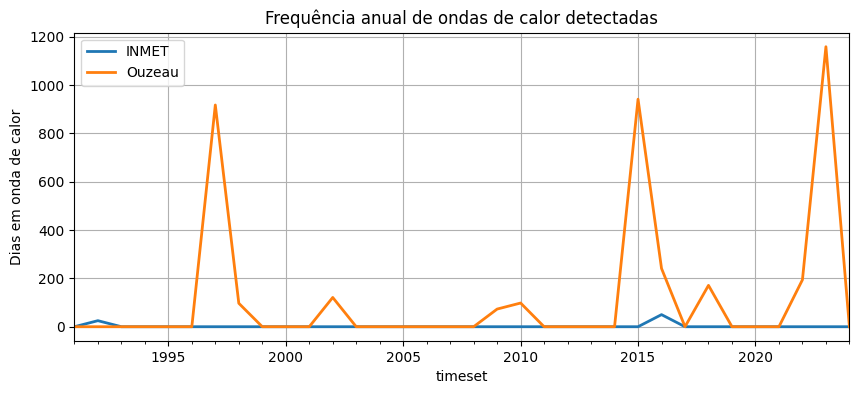

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
full["HW_INMET_bool"].resample("Y").sum().plot(label="INMET", lw=2)
full["HW_OU_bool"].resample("Y").sum().plot(label="Ouzeau", lw=2)
plt.ylabel("Dias em onda de calor")
plt.title("Frequência anual de ondas de calor detectadas")
plt.legend(); plt.grid(True)

Intensidade térmica e comparação entre métodos

In [8]:
cols_hw = ["HW_INMET_bool", "HW_OU_bool"]

# 1. Energia total já existente
full["ac_total_cool_kWh"] = (
    full.get("ac_SALA_Cool_E_kWh", 0) +
    full.get("ac_DORM1_Cool_E_kWh", 0) +
    full.get("ac_DORM2_Cool_E_kWh", 0)
)

# 2. Potência total instantânea
full["ac_total_cool_W"] = (
    full.get("ac_SALA_Cool_P_W", 0) +
    full.get("ac_DORM1_Cool_P_W", 0) +
    full.get("ac_DORM2_Cool_P_W", 0)
)

# 3. Criar dataframe base
df_hw = full[
    ["vn_DORM1_Top_C",
    "vn_DORM1_HeatIndex_C",
    "vn_DORM1_HumidityIndex",
    "jos3_t_skin_mean",
    "jos3_t_core",
    "ac_total_cool_W"
] 
    + cols_hw
]

# 4. Agrupar e pegar apenas médias
summary = df_hw.groupby(cols_hw).mean().round(1)

# 5. Renomear índices
mapping = {
    (False, False): "No heatwave",
    (True,  False): "INMET only",
    (False, True):  "Ouzeau only",
    (True,  True):  "Both"
}
summary.index = summary.index.map(mapping)

# 6. Reordenar categorias
summary = summary.loc[
    ["No heatwave", "INMET only", "Ouzeau only", "Both"]
]


summary


,vn_DORM1_Top_C,vn_DORM1_HeatIndex_C,vn_DORM1_HumidityIndex,jos3_t_skin_mean,jos3_t_core,ac_total_cool_W
No heatwave,30.9,35.8,41.7,35.5,36.8,1484.9
INMET only,33.3,41.9,46.3,35.7,36.8,1989.6
Ouzeau only,34.5,40.4,45.0,35.8,36.8,2096.4
Both,34.7,40.5,45.2,35.8,36.8,2170.4


In [ ]:
cols_hw = ["HW_INMET_bool", "HW_OU_bool"]

# 1. Energia total já existente
full["ac_total_cool_kWh"] = (
    full.get("ac_SALA_Cool_E_kWh", 0) +
    full.get("ac_DORM1_Cool_E_kWh", 0) +
    full.get("ac_DORM2_Cool_E_kWh", 0)
)

# 2. Potência total instantânea
full["ac_total_cool_W"] = (
    full.get("ac_SALA_Cool_P_W", 0) +
    full.get("ac_DORM1_Cool_P_W", 0) +
    full.get("ac_DORM2_Cool_P_W", 0)
)

# 3. Criar dataframe base
df_hw = full[
    ["vn_DORM1_Top_C",
    "vn_DORM1_HeatIndex_C",
    "vn_DORM1_HumidityIndex",
    "jos3_t_skin_mean",
    "jos3_t_core",
    "ac_total_cool_W"
] 
    + cols_hw
]

# 4. Agrupar e pegar apenas máximas
summary = df_hw.groupby(cols_hw).max().round(1)

# 5. Renomear índices
mapping = {
    (False, False): "No heatwave",
    (True,  False): "INMET only",
    (False, True):  "Ouzeau only",
    (True,  True):  "Both"
}
summary.index = summary.index.map(mapping)

# 6. Reordenar categorias
summary = summary.loc[
    ["No heatwave", "INMET only", "Ouzeau only", "Both"]
]


summary


,vn_DORM1_Top_C,vn_DORM1_HeatIndex_C,vn_DORM1_HumidityIndex,jos3_t_skin_mean,jos3_t_core,ac_total_cool_W
No heatwave,38.9,63.5,58.2,36.7,37.2,5379.6
INMET only,37.2,53.2,53.6,36.0,36.9,4375.2
Ouzeau only,39.4,61.1,58.0,36.6,37.2,5528.0
Both,38.3,45.5,48.9,36.0,36.9,4511.0


Comparativo direto entre métodos (INMET vs Ouzeau)

In [10]:
cross = pd.crosstab(full["HW_INMET_bool"], full["HW_OU_bool"])
print(cross)

# interseção: ambos detectam
both = full.loc[full["HW_INMET_bool"] & full["HW_OU_bool"]]
print("dias detectados por ambos:", both.resample("D").size().sum())

HW_OU_bool      False  True 
HW_INMET_bool               
False          285044   3961
True               25     50
dias detectados por ambos: 50


In [11]:
intersect = both.shape[0]
union = full.loc[full["HW_INMET_bool"] | full["HW_OU_bool"]].shape[0]
print(f"Sobrelapso INMET ∩ Ouzeau = {100*intersect/union:.1f}% dos registros de onda")

Sobrelapso INMET ∩ Ouzeau = 1.2% dos registros de onda


Resposta fisiológica (JOS-3) em ondas de calor

In [49]:
by_event = (full.dropna(subset=["INMET_hw_id"])
            .groupby("INMET_hw_id")[["jos3_t_core","jos3_t_skin_mean","ta_c"]]
            .agg(["mean","max"])
            .round(2))
display(by_event)

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\1146990520.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("INMET_hw_id")[["jos3_t_core","jos3_t_skin_mean","ta_c"]]


jos3_t_core        jos3_t_skin_mean          ta_c      
                              mean    max             mean    max   mean   max
INMET_hw_id                                                                   
MAO-INMET-19920201-001       36.85  36.95            35.73  36.07  29.71  36.0
MAO-INMET-20160110-001       36.84  36.89            35.75  35.94  30.83  36.0
MAO-INMET-20160117-002       36.86  36.92            35.82  36.01  31.35  37.0

In [50]:
by_event = (full.dropna(subset=["OUZ_hw_id"])
            .groupby("OUZ_hw_id")[["jos3_t_core","jos3_t_skin_mean","ta_c"]]
            .agg(["mean","max"])
            .round(2))
display(by_event)

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\3433019907.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("OUZ_hw_id")[["jos3_t_core","jos3_t_skin_mean","ta_c"]]


jos3_t_core        jos3_t_skin_mean          ta_c  \
                               mean    max             mean    max   mean   
OUZ_hw_id                                                                   
MAO-Ouzeau-19970911-001       36.84  36.96            35.71  36.07  30.27   
MAO-Ouzeau-19970930-002       36.84  36.89            35.72  35.91  29.74   
MAO-Ouzeau-19971012-003       36.88  36.99            35.84  36.16  30.61   
MAO-Ouzeau-19971021-004       36.86  36.92            35.80  35.98  29.65   
MAO-Ouzeau-19971025-005       36.88  37.18            35.83  36.55  30.68   
MAO-Ouzeau-19981006-001       36.84  36.97            35.73  36.10  29.65   
MAO-Ouzeau-20021008-001       36.84  36.88            35.72  35.92  29.86   
MAO-Ouzeau-20091006-001       36.83  36.87            35.69  35.88  29.67   
MAO-Ouzeau-20100929-001       36.84  36.94            35.74  36.03  29.61   
MAO-Ouzeau-20101030-002       36.84  37.00            35.72  36.19  29.22   
MAO-Ouzeau-20150906-001       36.83  36.90            35.69  35.92  30.14   
MAO-Ouzeau-20150917-002       36.84  36.89            35.76  35.96  31.20   
MAO-Ouzeau-20151008-003       36.84  36.91            35.75  35.95  30.78   
MAO-Ouzeau-20151015-004       36.85  36.95            35.78  36.06  30.71   
MAO-Ouzeau-20151022-005       36.85  36.91            35.76  35.98  29.67   
MAO-Ouzeau-20160109-001       36.85  36.92            35.76  36.01  30.19   
MAO-Ouzeau-20181009-001       36.84  36.89            35.73  35.93  29.60   
MAO-Ouzeau-20181016-002       36.84  36.89            35.73  35.93  29.52   
MAO-Ouzeau-20181025-003       36.84  36.88            35.73  35.91  29.65   
MAO-Ouzeau-20220927-001       36.84  36.88            35.72  35.90  29.83   
MAO-Ouzeau-20221006-002       36.83  36.88            35.69  35.91  29.65   
MAO-Ouzeau-20230820-001       36.83  36.87            35.70  35.88  30.03   
MAO-Ouzeau-20230901-002       36.83  36.88            35.71  35.91  29.93   
MAO-Ouzeau-20230909-003       36.84  36.89            35.73  35.91  30.26   
MAO-Ouzeau-20230929-004       36.85  36.91            35.79  36.00  30.54   
MAO-Ouzeau-20231026-005       36.86  36.92            35.79  36.01  30.06   
MAO-Ouzeau-20231110-006       36.86  36.92            35.79  36.00  30.22   

                               
                          max  
OUZ_hw_id                      
MAO-Ouzeau-19970911-001  38.0  
MAO-Ouzeau-19970930-002  38.0  
MAO-Ouzeau-19971012-003  38.0  
MAO-Ouzeau-19971021-004  38.0  
MAO-Ouzeau-19971025-005  38.0  
MAO-Ouzeau-19981006-001  38.0  
MAO-Ouzeau-20021008-001  37.0  
MAO-Ouzeau-20091006-001  36.0  
MAO-Ouzeau-20100929-001  37.0  
MAO-Ouzeau-20101030-002  36.0  
MAO-Ouzeau-20150906-001  37.0  
MAO-Ouzeau-20150917-002  39.0  
MAO-Ouzeau-20151008-003  37.0  
MAO-Ouzeau-20151015-004  38.0  
MAO-Ouzeau-20151022-005  38.0  
MAO-Ouzeau-20160109-001  37.0  
MAO-Ouzeau-20181009-001  37.0  
MAO-Ouzeau-20181016-002  36.0  
MAO-Ouzeau-20181025-003  36.0  
MAO-Ouzeau-20220927-001  37.0  
MAO-Ouzeau-20221006-002  36.0  
MAO-Ouzeau-20230820-001  37.0  
MAO-Ouzeau-20230901-002  37.0  
MAO-Ouzeau-20230909-003  37.0  
MAO-Ouzeau-20230929-004  38.0  
MAO-Ouzeau-20231026-005  37.0  
MAO-Ouzeau-20231110-006  37.0

Indoor overheating outside detected heatwaves

In [13]:
cols = [
    "vn_DORM1_Top_C",
    "vn_DORM1_HeatIndex_C",
    "vn_DORM1_HumidityIndex",
    "jos3_t_skin_mean",
    "jos3_t_core",
    "ac_total_cool_W"
]

full[cols].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]).round(2)

,vn_DORM1_Top_C,vn_DORM1_HeatIndex_C,vn_DORM1_HumidityIndex,jos3_t_skin_mean,jos3_t_core,ac_total_cool_W
count,289072.00,289072.00,289072.00,289072.00,289072.00,289072.00
mean,30.97,35.82,41.77,35.47,36.79,1493.40
std,2.28,4.19,3.13,0.19,0.04,1118.16
min,22.92,21.53,27.84,33.70,36.42,0.00
50%,30.71,35.46,41.58,35.48,36.78,1416.05
75%,32.55,38.58,43.86,35.62,36.81,2365.91
90%,34.14,41.39,45.92,35.72,36.84,3019.84
95%,35.05,43.10,47.16,35.78,36.85,3335.31
99%,36.63,46.66,49.64,35.89,36.88,3919.18
max,39.39,63.47,58.15,36.67,37.24,5528.01


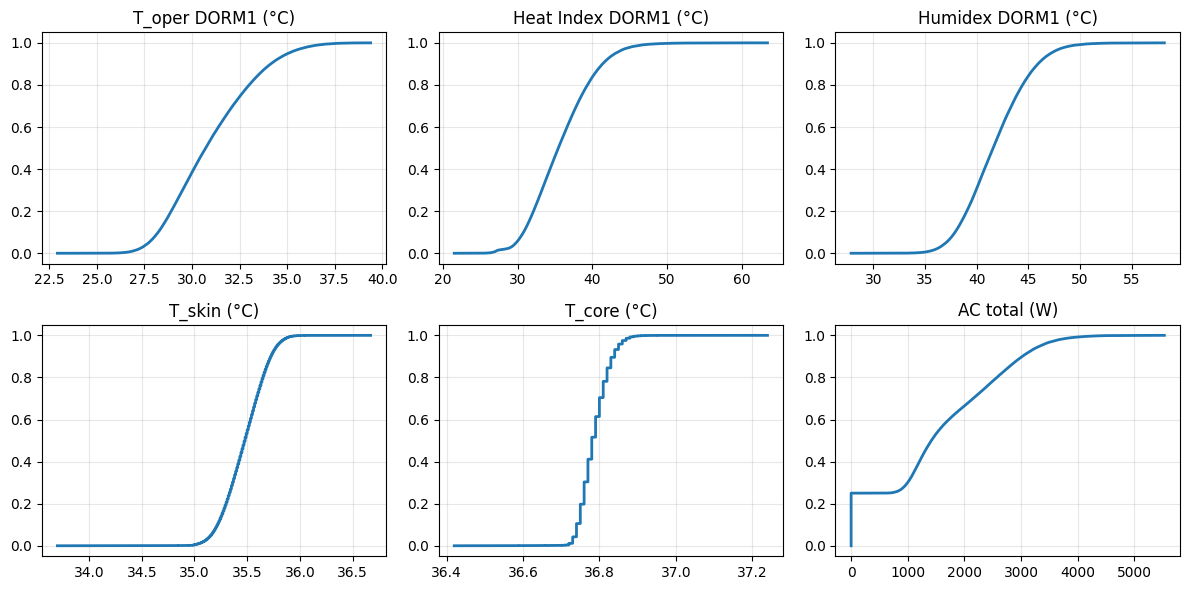

In [15]:
labels = [
    "T_oper DORM1 (°C)",
    "Heat Index DORM1 (°C)",
    "Humidex DORM1 (°C)",
    "T_skin (°C)",
    "T_core (°C)",
    "AC total (W)",
]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.ravel()

for ax, col, label in zip(axes, cols, labels):
    x = np.sort(full[col].dropna())
    y = np.linspace(0, 1, len(x))
    ax.plot(x, y, lw=2)
    ax.set_title(label)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Coocorrência de indicadores internos em overheating

In [16]:
internal_vars = [
    "vn_DORM1_Top_C",
    "vn_DORM1_HeatIndex_C",
    "vn_DORM1_HumidityIndex",
    "jos3_t_skin_mean",
    "jos3_t_core",
    "ac_total_cool_W"
]

N = len(full)
frac_extreme = 0.01          # top 1%
n_ext = max(1, int(round(frac_extreme * N)))

print("Total de linhas:", N, "| Horas extremas por variável:", n_ext)

thresholds = {}

for col in internal_vars:
    flag_col = f"flag_extreme_{col}"

    # índices das n_ext maiores observações
    idx_top = full[col].nlargest(n_ext).index
    
    # threshold real (menor valor entre os n_ext maiores)
    thr_val = full.loc[idx_top, col].min()
    thresholds[col] = thr_val

    # cria flag booleana
    full[flag_col] = False
    full.loc[idx_top, flag_col] = True

# checar contagem
hours_above = full[[f"flag_extreme_{c}" for c in internal_vars]].sum()
hours_above.to_frame("hours_extreme").T

# mostrar thresholds usados
print("=== Thresholds usados (mínimo dentro do top 1%) ===")
for col, thr in thresholds.items():
    print(f"{col:28s} → {thr:.3f}")

print()

Total de linhas: 289080 | Horas extremas por variável: 2891
=== Thresholds usados (mínimo dentro do top 1%) ===
vn_DORM1_Top_C               → 36.633
vn_DORM1_HeatIndex_C         → 46.662
vn_DORM1_HumidityIndex       → 49.639
jos3_t_skin_mean             → 35.890
jos3_t_core                  → 36.880
ac_total_cool_W              → 3919.400



<Axes: >

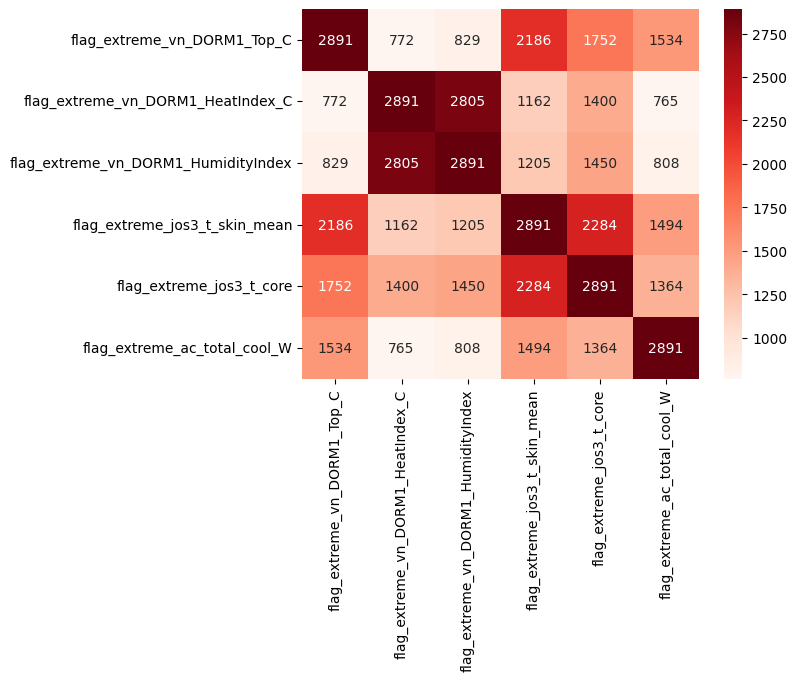

In [17]:
flags = [f"flag_extreme_{col}" for col in internal_vars]

co_matrix = pd.DataFrame(np.zeros((len(flags), len(flags))), 
                         index=flags, columns=flags)

for a in flags:
    for b in flags:
        co_matrix.loc[a, b] = (full[a] & full[b]).sum()

sns.heatmap(co_matrix, annot=True, fmt=".0f", cmap="Reds")

In [18]:
import itertools
rows = []
for a, b in itertools.combinations(flags, 2):
    A = full[a]
    B = full[b]
    inter = (A & B).sum()
    rows.append({
        "A": a,
        "B": b,
        "intersection_hours": inter,
        "% of A": round(100 * inter / A.sum(), 2),
        "% of B": round(100 * inter / B.sum(), 2),
    })

overlaps_df = pd.DataFrame(rows).sort_values("intersection_hours", ascending=False)
overlaps_df

,A,B,intersection_hours,% of A,% of B
5,flag_extreme_vn_DORM1_HeatIndex_C,flag_extreme_vn_DORM1_HumidityIndex,2805,97.03,97.03
12,flag_extreme_jos3_t_skin_mean,flag_extreme_jos3_t_core,2284,79.00,79.00
2,flag_extreme_vn_DORM1_Top_C,flag_extreme_jos3_t_skin_mean,2186,75.61,75.61
3,flag_extreme_vn_DORM1_Top_C,flag_extreme_jos3_t_core,1752,60.60,60.60
4,flag_extreme_vn_DORM1_Top_C,flag_extreme_ac_total_cool_W,1534,53.06,53.06
13,flag_extreme_jos3_t_skin_mean,flag_extreme_ac_total_cool_W,1494,51.68,51.68
10,flag_extreme_vn_DORM1_HumidityIndex,flag_extreme_jos3_t_core,1450,50.16,50.16
7,flag_extreme_vn_DORM1_HeatIndex_C,flag_extreme_jos3_t_core,1400,48.43,48.43
14,flag_extreme_jos3_t_core,flag_extreme_ac_total_cool_W,1364,47.18,47.18
9,flag_extreme_vn_DORM1_HumidityIndex,flag_extreme_jos3_t_skin_mean,1205,41.68,41.68


In [19]:
cols_hw = ["HW_INMET_bool", "HW_OU_bool"]
cols_ext = [c for c in full.columns if c.startswith("flag_extreme_")]

cooc = pd.crosstab(
    [full["HW_INMET_bool"], full["HW_OU_bool"]],
    [full[c] for c in cols_ext],
)

cooc

flag_extreme_vn_DORM1_Top_C           False                                \
flag_extreme_vn_DORM1_HeatIndex_C     False                                 
flag_extreme_vn_DORM1_HumidityIndex   False                                 
flag_extreme_jos3_t_skin_mean         False                   True          
flag_extreme_jos3_t_core              False       True        False         
flag_extreme_ac_total_cool_W          False True  False True  False True    
HW_INMET_bool HW_OU_bool                                                    
False         False                  279459  1059   212    27    33     6   
              True                     2889    54    25     1     9     0   
True          False                      16     1     1     0     0     0   
              True                       36     1     0     0     0     0   

flag_extreme_vn_DORM1_Top_C                                  ... True         \
flag_extreme_vn_DORM1_HeatIndex_C                            ... False         
flag_extreme_vn_DORM1_HumidityIndex             True         ... True          
flag_extreme_jos3_t_skin_mean                   False        ... True          
flag_extreme_jos3_t_core            True        False        ... True          
flag_extreme_ac_total_cool_W        False True  False True   ... False True    
HW_INMET_bool HW_OU_bool                                     ...               
False         False                   154    20    14     8  ...    12    25   
              True                     36     1     0     1  ...     6     2   
True          False                     1     0     0     0  ...     0     0   
              True                      0     0     0     0  ...     0     0   

flag_extreme_vn_DORM1_Top_C                                                    \
flag_extreme_vn_DORM1_HeatIndex_C   True                                        
flag_extreme_vn_DORM1_HumidityIndex True                                        
flag_extreme_jos3_t_skin_mean       False                   True                
flag_extreme_jos3_t_core            False       True        False       True    
flag_extreme_ac_total_cool_W        False True  False True  False True  False   
HW_INMET_bool HW_OU_bool                                                        
False         False                     6    10    12    11     1     6   106   
              True                      2     2     4     8     0     0    52   
True          False                     0     0     0     0     0     0     0   
              True                      0     0     0     0     0     0     0   

flag_extreme_vn_DORM1_Top_C                
flag_extreme_vn_DORM1_HeatIndex_C          
flag_extreme_vn_DORM1_HumidityIndex        
flag_extreme_jos3_t_skin_mean              
flag_extreme_jos3_t_core                   
flag_extreme_ac_total_cool_W        True   
HW_INMET_bool HW_OU_bool                   
False         False                   421  
              True                    129  
True          False                     2  
              True                      0  

[4 rows x 45 columns]

Porcentagem de horas com extremos internos durante HW

In [20]:
results = []

for hw_name, hw_mask in {
    "INMET only": (full["HW_INMET_bool"] & ~full["HW_OU_bool"]),
    "Ouzeau only": (~full["HW_INMET_bool"] & full["HW_OU_bool"]),
    "Both": (full["HW_INMET_bool"] & full["HW_OU_bool"]),
    "No HW": ~(full["HW_INMET_bool"] | full["HW_OU_bool"]),
}.items():

    subset = full[hw_mask]
    row = {"HW_category": hw_name, "hours": len(subset)}

    for col in cols_ext:
        row[col] = subset[col].mean() * 100  # % de horas extremas
    
    results.append(row)

pd.DataFrame(results)


,HW_category,hours,flag_extreme_vn_DORM1_Top_C,flag_extreme_vn_DORM1_HeatIndex_C,flag_extreme_vn_DORM1_HumidityIndex,flag_extreme_jos3_t_skin_mean,flag_extreme_jos3_t_core,flag_extreme_ac_total_cool_W
0,INMET only,25,12.000000,20.000000,20.000000,28.000000,32.000000,16.000000
1,Ouzeau only,3961,22.115627,6.614491,6.917445,19.464782,15.501136,12.572583
2,Both,50,26.000000,0.000000,0.000000,24.000000,14.000000,20.000000
3,No HW,285044,0.701295,0.920560,0.916350,0.737079,0.793562,0.834608


Severidade média dos eventos INMET vs Ouzeau

In [21]:
hw_stats = full.groupby("INMET_hw_id").agg({
    "INMET_duration_d": "max",
    "INMET_intensity_c": "max",
    "INMET_severity_cday": "max"
}).dropna()

ou_stats = full.groupby("OUZ_hw_id").agg({
    "OUZ_duration_d": "max",
    "OUZ_intensity_c": "max",
    "OUZ_severity_cday": "max"
}).dropna()

display(hw_stats.describe())
display(ou_stats.describe())

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\3653997329.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hw_stats = full.groupby("INMET_hw_id").agg({
C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\3653997329.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ou_stats = full.groupby("OUZ_hw_id").agg({


,INMET_duration_d,INMET_intensity_c,INMET_severity_cday
count,3.0,3.000000,3.000000
mean,2.0,31.027767,0.816268
std,0.0,0.751540,0.516780
min,2.0,30.250000,0.391677
25%,2.0,30.666650,0.528563
50%,2.0,31.083300,0.665448
75%,2.0,31.416650,1.028564
max,2.0,31.750000,1.391680


,OUZ_duration_d,OUZ_intensity_c,OUZ_severity_cday
count,27.000000,27.000000,27.000000
mean,7.148148,31.309504,5.841186
std,4.704365,0.614128,6.299105
min,2.000000,30.708300,1.041670
25%,4.000000,30.854150,2.104165
50%,5.000000,31.041700,3.541670
75%,9.000000,31.770850,6.635415
max,20.000000,32.791700,31.083300


In [22]:
pd.DataFrame({
    "INMET_mean": hw_stats.mean(),
    "OUZ_mean": ou_stats.mean()
})

,INMET_mean,OUZ_mean
INMET_duration_d,2.000000,NaN
INMET_intensity_c,31.027767,NaN
INMET_severity_cday,0.816268,NaN
OUZ_duration_d,NaN,7.148148
OUZ_intensity_c,NaN,31.309504
OUZ_severity_cday,NaN,5.841186


Alinhamento entre severidade do evento e resposta fisiológica

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\2112449320.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  events = full.groupby("INMET_hw_id").agg({


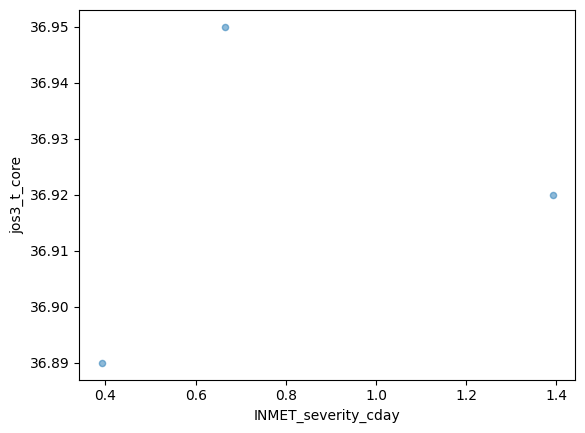

In [23]:
events = full.groupby("INMET_hw_id").agg({
    "INMET_severity_cday": "max",
    "jos3_t_core": "max",
    "jos3_t_skin_mean": "mean",
    "vn_DORM1_Top_C": "mean",
    "vn_DORM1_HeatIndex_C": "mean"
})

events.plot.scatter("INMET_severity_cday", "jos3_t_core", alpha=0.5);

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\71730893.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  events = full.groupby("OUZ_hw_id").agg({


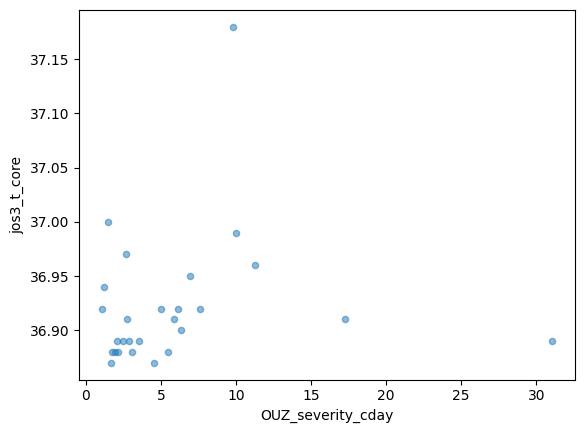

In [24]:
events = full.groupby("OUZ_hw_id").agg({
    "OUZ_severity_cday": "max",
    "jos3_t_core": "max",
    "jos3_t_skin_mean": "mean",
    "vn_DORM1_Top_C": "mean",
    "vn_DORM1_HeatIndex_C": "mean"
})

events.plot.scatter("OUZ_severity_cday", "jos3_t_core", alpha=0.5);

Que tipo de evento cada método está deixando escapar?

In [25]:
undetected = full[
    (full[cols_ext].any(axis=1)) &
    (~full["HW_INMET_bool"]) &
    (~full["HW_OU_bool"])
]

undetected.describe()[["vn_DORM1_Top_C", "vn_DORM1_HeatIndex_C",
                       "jos3_t_core", "jos3_t_skin_mean", "ac_total_cool_W"]]

,vn_DORM1_Top_C,vn_DORM1_HeatIndex_C,jos3_t_core,jos3_t_skin_mean,ac_total_cool_W
count,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000
mean,36.069186,46.086528,36.875490,35.859332,3699.496320
std,1.091071,3.433838,0.024202,0.078036,853.238192
min,31.364075,32.856997,36.790000,35.510000,0.000000
25%,35.307613,43.476990,36.860000,35.810000,3554.757881
50%,36.142521,46.299926,36.880000,35.870000,3842.329633
75%,36.852618,48.174736,36.890000,35.900000,4088.536961
max,38.943619,63.472718,37.240000,36.670000,5379.639745


Assinatura térmica dos quatro cenários de HW

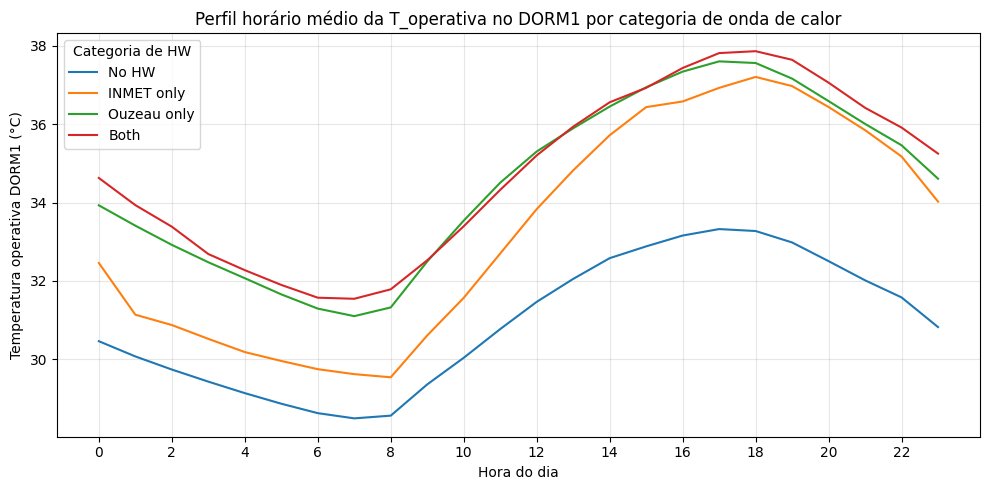

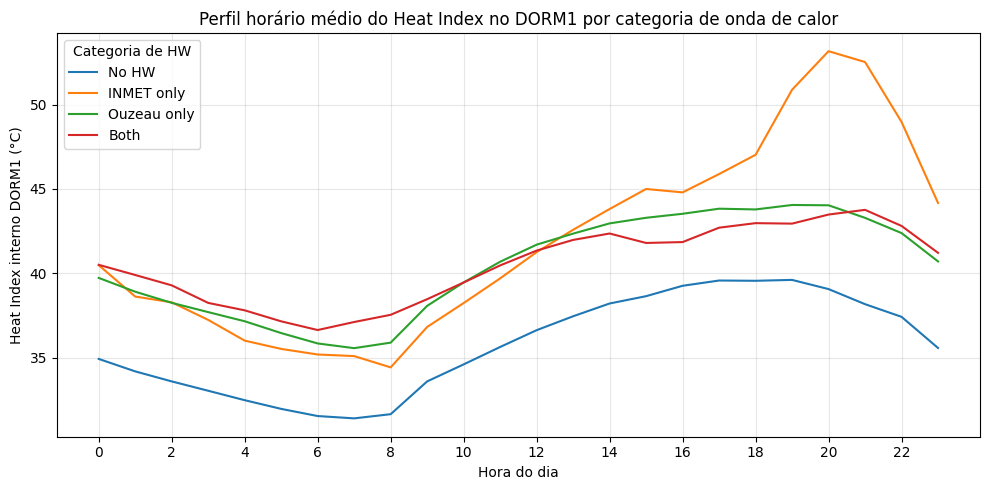

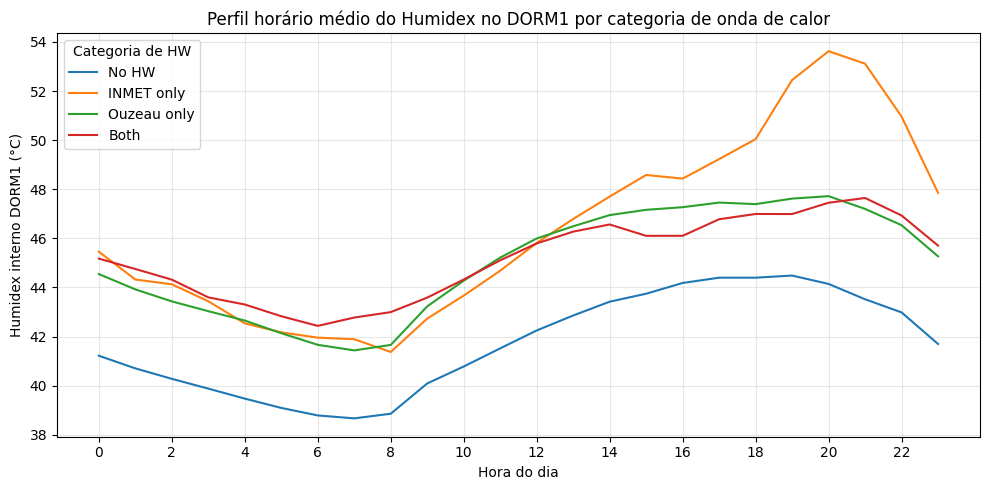

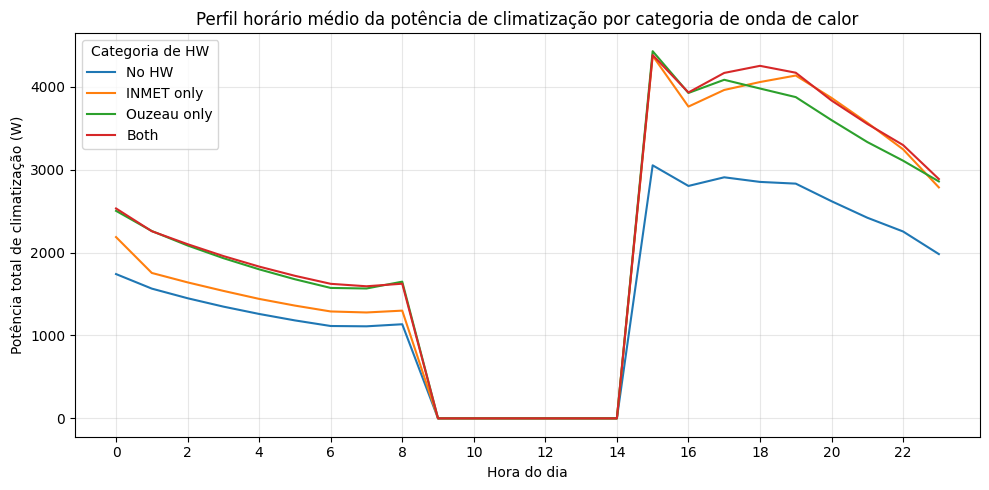

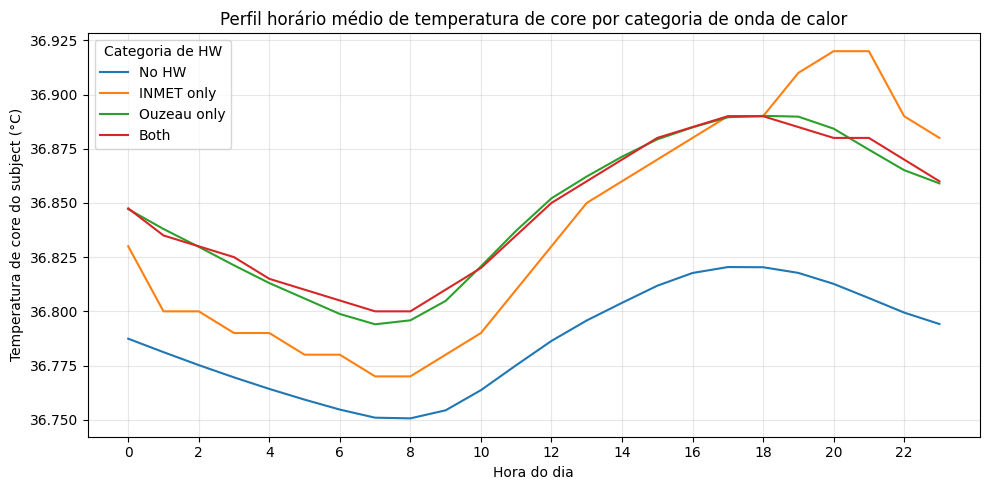

In [26]:
# -------- 1) Perfis horários médios por categoria de HW --------
tmp = full.copy()

# timeset é o índice (DatetimeIndex)
tmp["hour"] = tmp.index.hour

cats = {
    "No HW": ~(tmp["HW_INMET_bool"] | tmp["HW_OU_bool"]),
    "INMET only": (tmp["HW_INMET_bool"] & ~tmp["HW_OU_bool"]),
    "Ouzeau only": (~tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
    "Both": (tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
}

profiles = []

for name, mask in cats.items():
    prof = (
        tmp[mask]
        .groupby("hour")
        .mean(numeric_only=True)
    )
    prof["HW_category"] = name
    profiles.append(prof)

profiles = pd.concat(profiles)
prof_long = profiles.reset_index()  # traz 'hour' como coluna

# Paleta consistente
colors = {
    "No HW": "tab:blue",
    "INMET only": "tab:orange",
    "Ouzeau only": "tab:green",
    "Both": "tab:red",
}

# -------- 2) Função genérica pra plotar um indicador --------
def plot_indicator(col, ylabel, title):
    fig, ax = plt.subplots(figsize=(10, 5))

    for name, color in colors.items():
        sub = prof_long[prof_long["HW_category"] == name]
        ax.plot(
            sub["hour"],
            sub[col],
            label=name,
            color=color,
        )

    ax.set_xlabel("Hora do dia")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(title="Categoria de HW")
    plt.xticks(range(0, 24, 2))
    plt.tight_layout()
    plt.show()

# -------- 3) Gerar os gráficos individuais --------

# (a) Temperatura operativa no dormitório
plot_indicator(
    col="vn_DORM1_Top_C",
    ylabel="Temperatura operativa DORM1 (°C)",
    title="Perfil horário médio da T_operativa no DORM1 por categoria de onda de calor"
)

# (b) Heat Index
plot_indicator(
    col="vn_DORM1_HeatIndex_C",
    ylabel="Heat Index interno DORM1 (°C)",
    title="Perfil horário médio do Heat Index no DORM1 por categoria de onda de calor"
)

# (c) Humidex
plot_indicator(
    col="vn_DORM1_HumidityIndex",
    ylabel="Humidex interno DORM1 (°C)",
    title="Perfil horário médio do Humidex no DORM1 por categoria de onda de calor"
)

# (d) Potência total de climatização (soma das zonas)
plot_indicator(
    col="ac_total_cool_W",
    ylabel="Potência total de climatização (W)",
    title="Perfil horário médio da potência de climatização por categoria de onda de calor"
)

# (e) Potência total de climatização (soma das zonas)
plot_indicator(
    col="jos3_t_core",
    ylabel="Temperatura de core do subject (°C)",
    title="Perfil horário médio de temperatura de core por categoria de onda de calor"
)

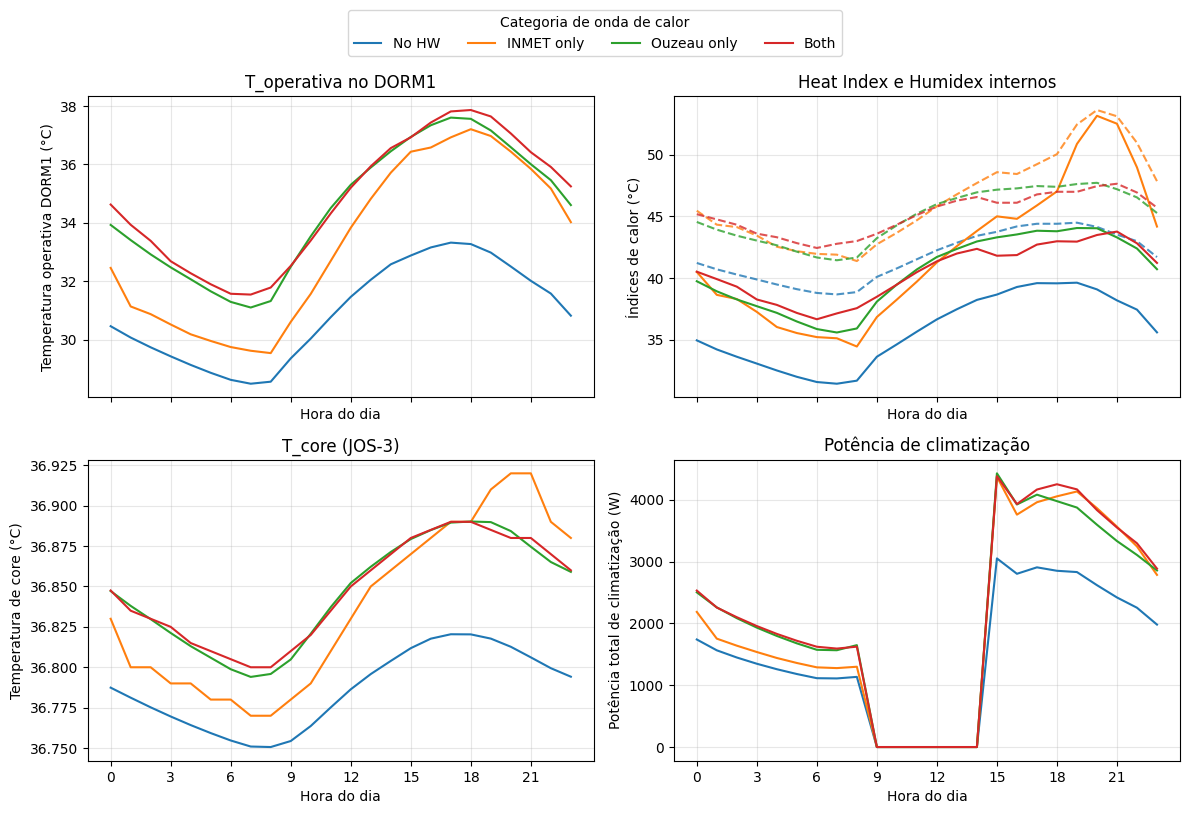

In [27]:
# -------- 1) Perfis horários médios por categoria de HW --------
tmp = full.copy()

# timeset é o índice (DatetimeIndex)
tmp["hour"] = tmp.index.hour

cats = {
    "No HW": ~(tmp["HW_INMET_bool"] | tmp["HW_OU_bool"]),
    "INMET only": (tmp["HW_INMET_bool"] & ~tmp["HW_OU_bool"]),
    "Ouzeau only": (~tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
    "Both": (tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
}

profiles = []

for name, mask in cats.items():
    prof = (
        tmp[mask]
        .groupby("hour")
        .mean(numeric_only=True)
    )
    prof["HW_category"] = name
    profiles.append(prof)

profiles = pd.concat(profiles)
prof_long = profiles.reset_index()  # traz 'hour' como coluna

# Paleta consistente
colors = {
    "No HW": "tab:blue",
    "INMET only": "tab:orange",
    "Ouzeau only": "tab:green",
    "Both": "tab:red",
}

# -------- 2) Grid 2x2 de subplots --------
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.ravel()

# Config por subplot
plots_cfg = [
    ("vn_DORM1_Top_C",
     "Temperatura operativa DORM1 (°C)",
     "T_operativa no DORM1"),
    ("HI+Humidex",          # marcador especial pra tratarmos diferente
     "Índices de calor (°C)",
     "Heat Index e Humidex internos"),
    ("jos3_t_core",
     "Temperatura de core (°C)",
     "T_core (JOS-3)"),
    ("ac_total_cool_W",
     "Potência total de climatização (W)",
     "Potência de climatização"),
]

all_lines = []

for ax, (col, ylabel, title) in zip(axes, plots_cfg):

    if col != "HI+Humidex":
        # Casos “normais”: uma variável por subplot
        lines = []
        for name, color in colors.items():
            sub = prof_long[prof_long["HW_category"] == name]
            (line,) = ax.plot(
                sub["hour"],
                sub[col],
                label=name,
                color=color,
            )
            lines.append(line)
        all_lines = lines  # mesma ordem de categorias em todos

    else:
        # Subplot especial: HI (linha cheia) + Humidex (linha pontilhada)
        for name, color in colors.items():
            sub = prof_long[prof_long["HW_category"] == name]

            # Heat Index - linha cheia
            ax.plot(
                sub["hour"],
                sub["vn_DORM1_HeatIndex_C"],
                label=f"{name} - HI",
                color=color,
                linestyle="-",
            )

            # Humidex - linha pontilhada
            ax.plot(
                sub["hour"],
                sub["vn_DORM1_HumidityIndex"],
                label=f"{name} - Humidex",
                color=color,
                linestyle="--",
                alpha=0.8,
            )

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 24, 3))

# eixo x comum
for ax in axes:
    ax.set_xlabel("Hora do dia")

# Legenda: só por categoria de HW (cores), pra não virar carnaval
# cria linhas “fake” só pra legenda
legend_lines = []
legend_labels = []
for name, color in colors.items():
    (ln,) = axes[0].plot([], [], color=color, label=name)  # linha vazia
    legend_lines.append(ln)
    legend_labels.append(name)

fig.legend(
    handles=legend_lines,
    labels=legend_labels,
    title="Categoria de onda de calor",
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, 1.02),
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


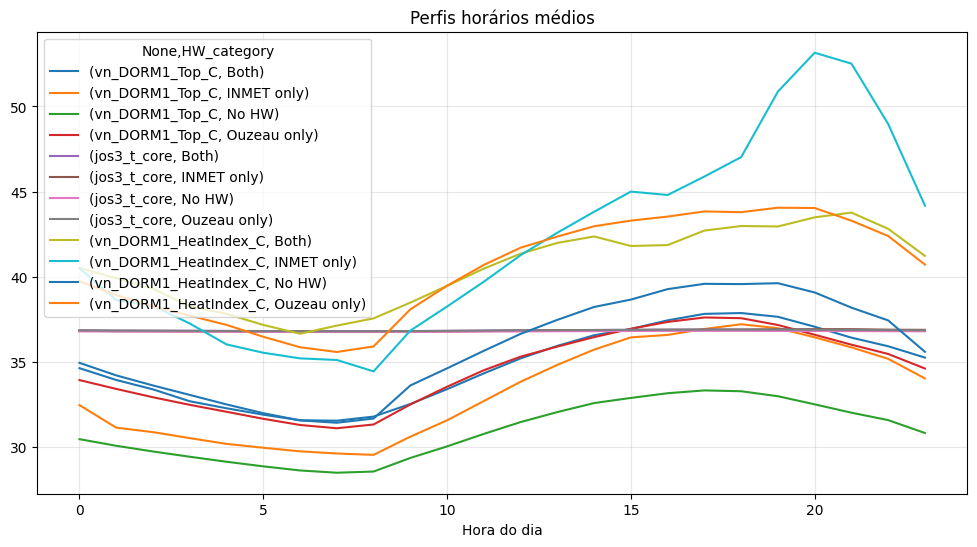

In [28]:
tmp = full.copy()

# timeset é o índice (DatetimeIndex)
tmp["hour"] = tmp.index.hour

cats = {
    "No HW": ~(tmp["HW_INMET_bool"] | tmp["HW_OU_bool"]),
    "INMET only": (tmp["HW_INMET_bool"] & ~tmp["HW_OU_bool"]),
    "Ouzeau only": (~tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
    "Both": (tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
}

profiles = []

for name, mask in cats.items():
    # média por hora do dia só das linhas daquela categoria
    prof = (
        tmp[mask]
        .groupby("hour")
        .mean(numeric_only=True)
    )
    prof["HW_category"] = name
    profiles.append(prof)

profiles = pd.concat(profiles)

(
    profiles[["vn_DORM1_Top_C", "jos3_t_core", "vn_DORM1_HeatIndex_C", "ac_total_cool_W", "HW_category"]]
    .reset_index()  # traz 'hour' de volta como coluna
    .pivot(index="hour", columns="HW_category", values=["vn_DORM1_Top_C",
                                                       "jos3_t_core",
                                                       "vn_DORM1_HeatIndex_C",
                                                       ])
    .plot(figsize=(12, 6), title="Perfis horários médios")
)

plt.xlabel("Hora do dia")
plt.grid(True, alpha=0.3)
plt.show()

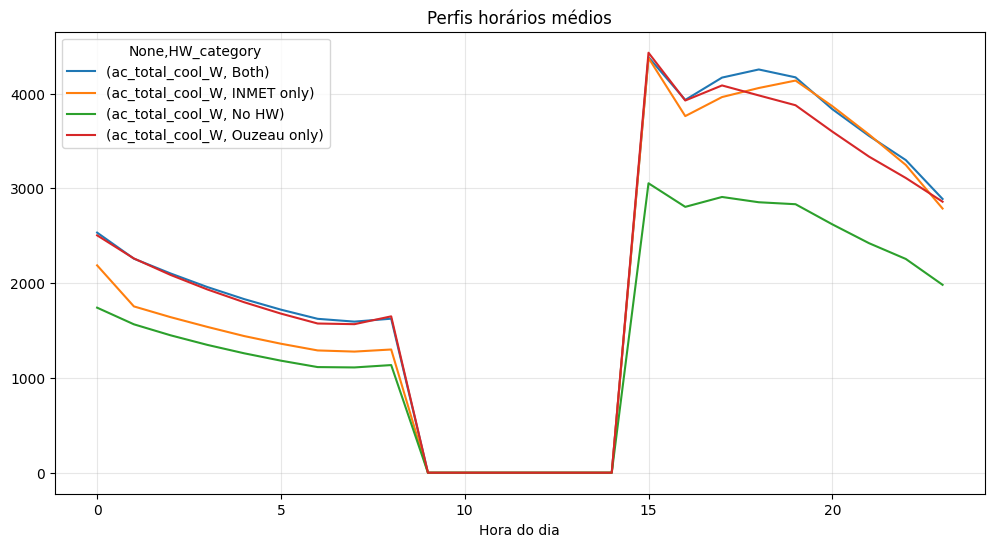

In [29]:
tmp = full.copy()

# timeset é o índice (DatetimeIndex)
tmp["hour"] = tmp.index.hour

cats = {
    "No HW": ~(tmp["HW_INMET_bool"] | tmp["HW_OU_bool"]),
    "INMET only": (tmp["HW_INMET_bool"] & ~tmp["HW_OU_bool"]),
    "Ouzeau only": (~tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
    "Both": (tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
}

profiles = []

for name, mask in cats.items():
    # média por hora do dia só das linhas daquela categoria
    prof = (
        tmp[mask]
        .groupby("hour")
        .mean(numeric_only=True)
    )
    prof["HW_category"] = name
    profiles.append(prof)

profiles = pd.concat(profiles)

(
    profiles[["ac_total_cool_W", "HW_category"]]
    .reset_index()  # traz 'hour' de volta como coluna
    .pivot(index="hour", columns="HW_category", values=["ac_total_cool_W"                                              
                                                       ])
    .plot(figsize=(12, 6), title="Perfis horários médios")
)

plt.xlabel("Hora do dia")
plt.grid(True, alpha=0.3)
plt.show()

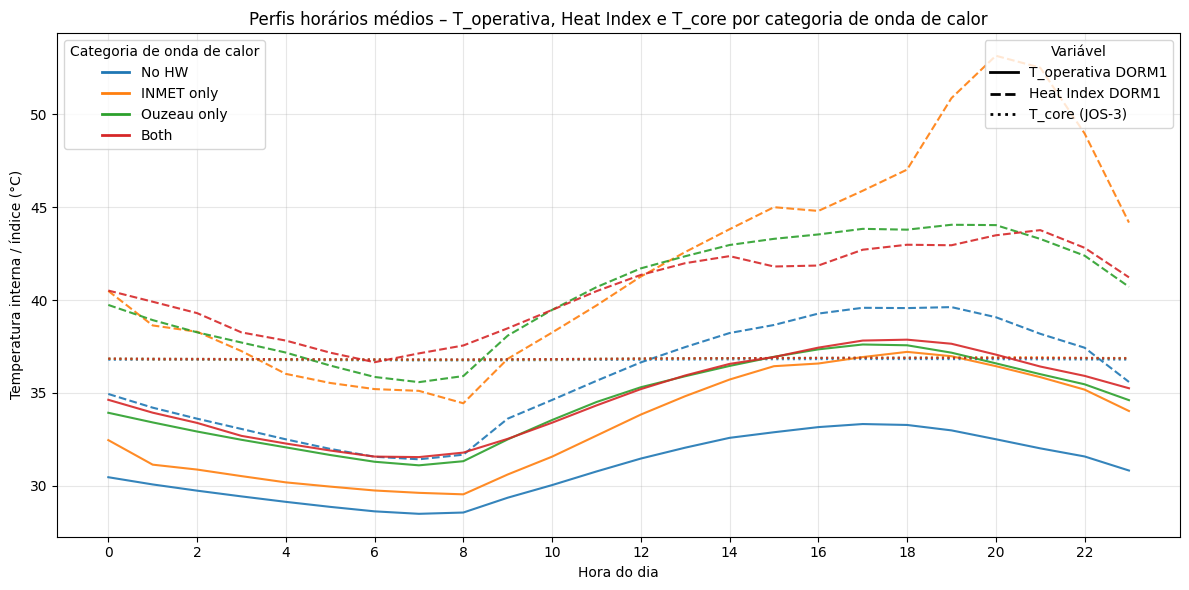

In [30]:
tmp = full.copy()
tmp["hour"] = tmp.index.hour

cats = {
    "No HW": ~(tmp["HW_INMET_bool"] | tmp["HW_OU_bool"]),
    "INMET only": (tmp["HW_INMET_bool"] & ~tmp["HW_OU_bool"]),
    "Ouzeau only": (~tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
    "Both": (tmp["HW_INMET_bool"] & tmp["HW_OU_bool"]),
}

profiles = []

for name, mask in cats.items():
    prof = (
        tmp[mask]
        .groupby("hour")
        .mean(numeric_only=True)
    )
    prof["HW_category"] = name
    profiles.append(prof)

profiles = pd.concat(profiles)
prof_long = profiles.reset_index()  # traz 'hour' como coluna

# cores por categoria (igual aos outros gráficos)
colors = {
    "No HW": "tab:blue",
    "INMET only": "tab:orange",
    "Ouzeau only": "tab:green",
    "Both": "tab:red",
}

# estilos por variável
var_styles = {
    "vn_DORM1_Top_C":      ("T_operativa DORM1", "-"),
    "vn_DORM1_HeatIndex_C":("Heat Index DORM1", "--"),
    "jos3_t_core":         ("T_core (JOS-3)", ":"),
}

fig, ax = plt.subplots(figsize=(12, 6))

# plota: para cada categoria (cor), todas as variáveis (linestyle diferente)
for cat_name, color in colors.items():
    sub_cat = prof_long[prof_long["HW_category"] == cat_name]

    for col, (label_var, ls) in var_styles.items():
        ax.plot(
            sub_cat["hour"],
            sub_cat[col],
            color=color,
            linestyle=ls,
            alpha=0.9,
            label=f"{cat_name} – {label_var}",
        )

ax.set_xlabel("Hora do dia")
ax.set_ylabel("Temperatura interna / índice (°C)")
ax.set_title("Perfis horários médios – T_operativa, Heat Index e T_core por categoria de onda de calor")
ax.set_xticks(range(0, 24, 2))
ax.grid(True, alpha=0.3)

# Agora arrumamos uma legenda mais limpa:
# 1) legenda de cores = categoria de HW
from matplotlib.lines import Line2D

legend_colors = [
    Line2D([0], [0], color=color, lw=2)
    for _, color in colors.items()
]
legend_color_labels = list(colors.keys())

# 2) legenda de estilos = variável
legend_styles = [
    Line2D([0], [0], color="black", linestyle=ls, lw=2)
    for _, (label_var, ls) in var_styles.items()
]
legend_style_labels = [label_var for label_var, _ in var_styles.values()]

# coloca as duas legendas
leg1 = ax.legend(
    handles=legend_colors,
    labels=legend_color_labels,
    title="Categoria de onda de calor",
    loc="upper left",
)
ax.add_artist(leg1)

ax.legend(
    handles=legend_styles,
    labels=legend_style_labels,
    title="Variável",
    loc="upper right",
)

plt.tight_layout()
plt.show()


In [31]:
# categorias já existentes
cats = {
    "No HW": ~(full["HW_INMET_bool"] | full["HW_OU_bool"]),
    "INMET only": (full["HW_INMET_bool"] & ~full["HW_OU_bool"]),
    "Ouzeau only": (~full["HW_INMET_bool"] & full["HW_OU_bool"]),
    "Both": (full["HW_INMET_bool"] & full["HW_OU_bool"]),
}

# paleta consistente
colors = {
    "No HW": "tab:blue",
    "INMET only": "tab:orange",
    "Ouzeau only": "tab:green",
    "Both": "tab:red",
}

def plot_ecdf_by_hw(var, xlabel=None, title=None):
    plt.figure(figsize=(7,5))

    for name, mask in cats.items():
        x = full.loc[mask, var].dropna().values
        x_sorted = np.sort(x)
        y = np.arange(1, len(x_sorted)+1) / len(x_sorted)
        
        plt.plot(x_sorted, y, label=f"{name} (n={len(x_sorted)})",
                 color=colors[name], linewidth=2)

    plt.xlabel(xlabel if xlabel else var)
    plt.ylabel("ECDF")
    plt.title(title if title else f"ECDF de {var} por categoria de HW")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

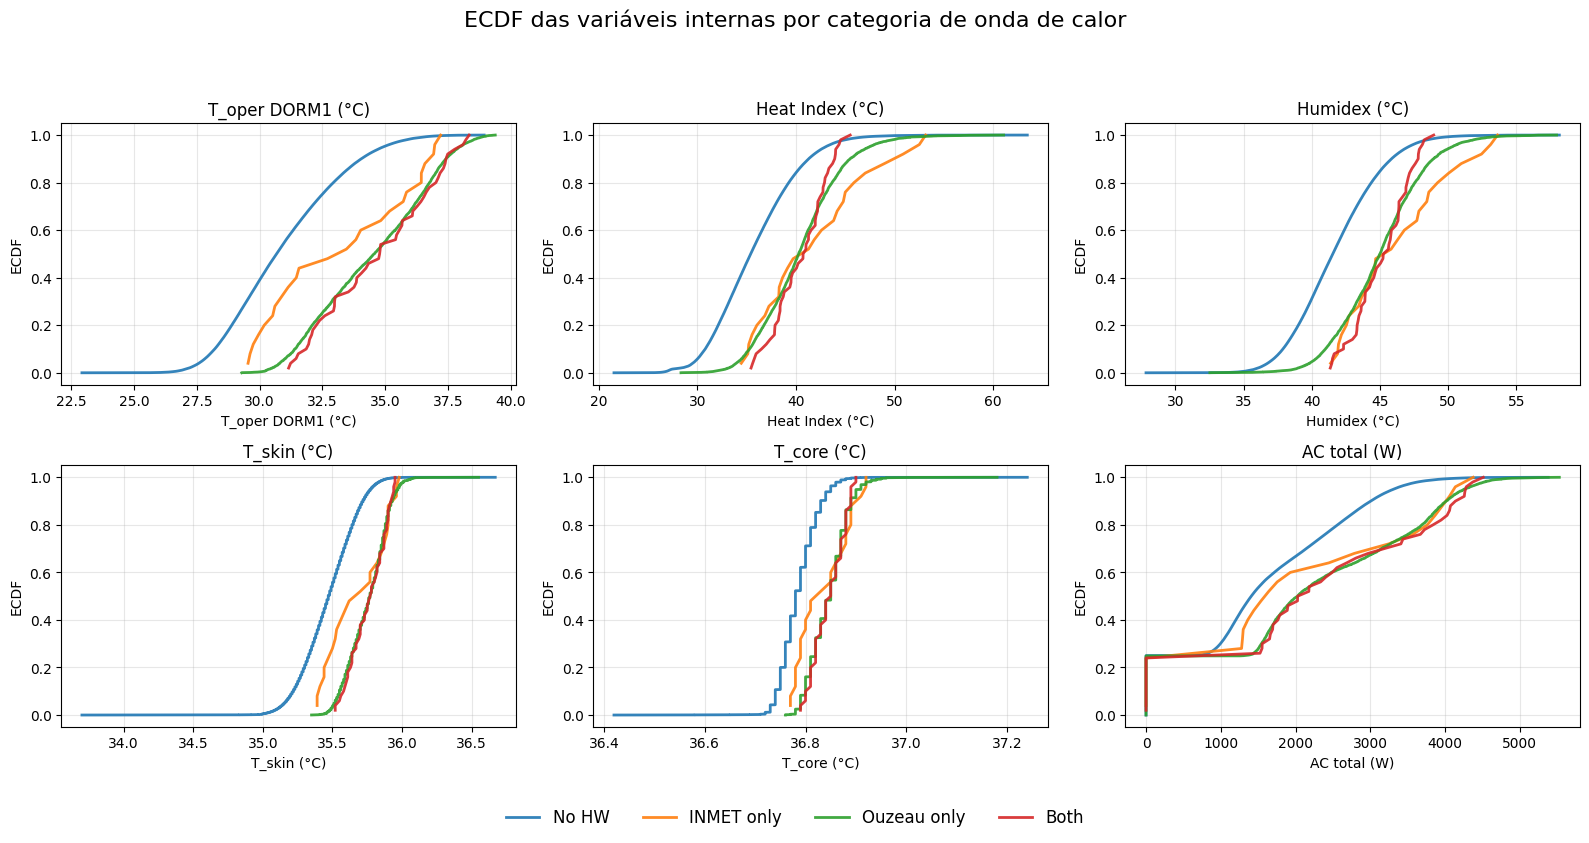

In [32]:
vars_ecdf = [
    ("vn_DORM1_Top_C",         "T_oper DORM1 (°C)"),
    ("vn_DORM1_HeatIndex_C",   "Heat Index (°C)"),
    ("vn_DORM1_HumidityIndex", "Humidex (°C)"),
    ("jos3_t_skin_mean",       "T_skin (°C)"),
    ("jos3_t_core",            "T_core (°C)"),
    ("ac_total_cool_W",        "AC total (W)"),
]

colors = {
    "No HW": "tab:blue",
    "INMET only": "tab:orange",
    "Ouzeau only": "tab:green",
    "Both": "tab:red",
}

cats = {
    "No HW": ~(full["HW_INMET_bool"] | full["HW_OU_bool"]),
    "INMET only": (full["HW_INMET_bool"] & ~full["HW_OU_bool"]),
    "Ouzeau only": (~full["HW_INMET_bool"] & full["HW_OU_bool"]),
    "Both": (full["HW_INMET_bool"] & full["HW_OU_bool"]),
}

# -----------------------------
#  CONFIGURAÇÕES DO GRID
# -----------------------------
ncols = 3
nrows = int(np.ceil(len(vars_ecdf) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
axes = axes.flatten()  # para indexar facilmente

# -----------------------------
#  PLOTAR CADA VARIÁVEL
# -----------------------------
for ax, (var, label) in zip(axes, vars_ecdf):

    for name, mask in cats.items():
        x = full.loc[mask, var].dropna().values
        x_sorted = np.sort(x)
        y = np.arange(1, len(x_sorted)+1) / len(x_sorted)

        ax.plot(
            x_sorted, y,
            color=colors[name],
            label=name,
            linewidth=2,
            alpha=0.9
        )

    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("ECDF")
    ax.grid(True, alpha=0.3)

# -----------------------------
#  REMOVER EIXOS VAZIOS (caso nvars < nrows*ncols)
# -----------------------------
for j in range(len(vars_ecdf), len(axes)):
    fig.delaxes(axes[j])

# -----------------------------
# LEGENDA GLOBAL 
# -----------------------------
fig.legend(
    cats.keys(),
    loc="lower center",
    ncol=4,
    frameon=False,
    fontsize=12,
    bbox_to_anchor=(0.5, -0.02)
)

# -----------------------------
# TÍTULO GLOBAL
# -----------------------------
fig.suptitle("ECDF das variáveis internas por categoria de onda de calor", fontsize=16, y=1.02)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])  # deixa espaço para a legenda inferior
plt.show()

Qual método melhor prediz risco fisiológico?

In [33]:
full["risk_score"] = (
    0.5 * (full["jos3_t_skin_mean"] - full["jos3_t_skin_mean"].mean()) +
    0.5 * (full["jos3_t_core"] - full["jos3_t_core"].mean())
)

In [34]:
full.groupby(["HW_INMET_bool","HW_OU_bool"]).risk_score.mean().round(3)

HW_INMET_bool  HW_OU_bool
False          False        -0.002
               True          0.169
True           False         0.130
               True          0.174
Name: risk_score, dtype: float64

Indicadores das ondas de calor vs indoor 

In [35]:
def classify_event(row):
    IN = row["HW_INMET_bool"]
    OU = row["HW_OU_bool"]
    if IN and OU: return "Both"
    if IN and not OU: return "INMET only"
    if OU and not IN: return "Ouzeau only"
    return "No heatwave"

full["HW_category"] = full.apply(classify_event, axis=1)

In [36]:
full["AC_energy"] = (
    full.get("ac_SALA_Cool_E_kWh", 0)
    + full.get("ac_DORM1_Cool_E_kWh", 0)
    + full.get("ac_DORM2_Cool_E_kWh", 0)
)

full["AC_power"] = (
    full.get("ac_SALA_Cool_P_W", 0)
    + full.get("ac_DORM1_Cool_P_W", 0)
    + full.get("ac_DORM2_Cool_P_W", 0)
)

In [37]:
inmet_events = (
    full.dropna(subset=["INMET_hw_id"])
        .groupby("INMET_hw_id")
        .agg({
            "INMET_duration_d": "first",
            "INMET_intensity_c": "first",
            "INMET_severity_cday": "first",
            "ta_c": "mean",
            "jos3_t_skin_mean": "mean",
            "jos3_t_core": "mean",
            "vn_DORM1_HeatIndex_C": "mean",
            "vn_DORM1_HumidityIndex": "mean",
            "vn_DORM1_Top_C": "mean",
            "AC_energy": "sum",
            "AC_power": "mean",
            "HW_category": lambda x: x.mode()[0],
        })
        .rename(columns={
            "ta_c": "T_ar_mean",
            "jos3_t_skin_mean": "T_skin_mean",
            "jos3_t_core": "T_core_mean",
            "AC_energy": "AC_energy_total",
            "AC_power": "AC_power_mean"
        })
)

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\183161484.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("INMET_hw_id")


In [38]:
ouz_events = (
    full.dropna(subset=["OUZ_hw_id"])
        .groupby("OUZ_hw_id")
        .agg({
            "OUZ_duration_d": "first",
            "OUZ_intensity_c": "first",
            "OUZ_severity_cday": "first",
            "ta_c": "mean",
            "jos3_t_skin_mean": "mean",
            "jos3_t_core": "mean",
            "vn_DORM1_HeatIndex_C": "mean",
            "vn_DORM1_HumidityIndex": "mean",
            "vn_DORM1_Top_C": "mean",
            "AC_energy": "sum",
            "AC_power": "mean",
            "HW_category": lambda x: x.mode()[0],
        })
        .rename(columns={
            "ta_c": "T_ar_mean",
            "jos3_t_skin_mean": "T_skin_mean",
            "jos3_t_core": "T_core_mean",
            "AC_energy": "AC_energy_total",
            "AC_power": "AC_power_mean"
        })
)


C:\Users\Matheus\AppData\Local\Temp\ipykernel_18220\282518093.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("OUZ_hw_id")


In [39]:
event_summary = (
    pd.concat([
        inmet_events.assign(method="INMET"),
        ouz_events.assign(method="Ouzeau")
    ])
    .groupby("HW_category")
    .agg({
        "T_ar_mean": "mean",
        "T_skin_mean": "mean",
        "T_core_mean": "mean",
        "vn_DORM1_HeatIndex_C": "mean",
        "vn_DORM1_HumidityIndex": "mean",
        "vn_DORM1_Top_C": "mean",
        "AC_energy_total": "mean",
        "AC_power_mean": "mean",
        "INMET_duration_d": "mean",
        "OUZ_duration_d": "mean",
        "INMET_intensity_c": "mean",
        "OUZ_intensity_c": "mean",
        "INMET_severity_cday": "mean",
        "OUZ_severity_cday": "mean"
    })
    .round(2)
)

In [40]:
event_summary

,T_ar_mean,T_skin_mean,T_core_mean,vn_DORM1_HeatIndex_C,vn_DORM1_HumidityIndex,vn_DORM1_Top_C,AC_energy_total,AC_power_mean,INMET_duration_d,OUZ_duration_d,INMET_intensity_c,OUZ_intensity_c,INMET_severity_cday,OUZ_severity_cday
HW_category,,,,,,,,,,,,,,
Both,31.09,35.78,36.85,40.77,45.35,35.09,105.64,2200.76,2.0,NaN,31.42,NaN,0.89,NaN
INMET only,29.71,35.73,36.85,43.41,47.36,33.74,98.35,2048.95,2.0,NaN,30.25,NaN,0.67,NaN
Ouzeau only,30.03,35.74,36.84,40.13,44.81,34.29,355.07,2053.45,NaN,7.15,NaN,31.31,NaN,5.84
